In [1]:
import pickle
import numpy as np 
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt 

import sklearn.metrics
from sklearn.model_selection import train_test_split
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 22

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
%matplotlib widget


In [2]:
with open('../../data/processed/supervised_dict_reduced_170522.pickle', 'rb') as file: 
    supervised_dict = pickle.load(file) 
    
JET_PDB = pd.read_csv('../../../moxie/data/processed/jet-pedestal-database.csv')
PULSE_DF_SANDBOX = JET_PDB[(JET_PDB['FLAG:HRTSdatavalidated'] > 0) & (JET_PDB['shot'] > 80000) & (JET_PDB['Atomicnumberofseededimpurity'].isin([0, 7])) & (JET_PDB['FLAG:DEUTERIUM'] == 1.0) & (JET_PDB['FLAG:Kicks'] == 0.0) & (JET_PDB['FLAG:RMP'] == 0.0) & (JET_PDB['FLAG:pellets'] == 0.0)]
relevant_columns = ['shot', 'nepedheight10^19(m^-3)','Tepedheight(keV)', 'B(T)','Ip(MA)', 'q95',  'R(m)', 'a(m)','gasflowrateofmainspecies10^22(e/s)',  'P_TOT=PNBI+Pohm+PICRH-Pshi(MW)', 'P_ICRH(MW)', 'P_NBI(MW)','plasmavolume(m^3)', 'averagetriangularity', 'divertorconfiguration', 'FLAG:Seeding', 'FLAG:Kicks',
 'FLAG:RMP',
 'FLAG:pellets',]
mp_cols = ['Q95', 'RGEO', 'CR0', 'VOLM', 'TRIU', 'TRIL', 'ELON', 'POHM', 'IPLA', 'BVAC', 'NBI', 'ICRH', 'ELER'] # supervised_dict['MP_ORDER']

In [3]:
def standardize(x, mu=None, var=None): 
    if mu is None and var is None: 
        mu = x.mean(0)
        var = x.std(0)
        x_normed = (x - mu ) / var
        return x_normed, mu, var
    else: 
        return (x - mu) / var
    
def standardize_mps(x, mu=None, var=None): 
    x_normed = np.copy(x)
    if mu is None and var is None: 
        mu = x[:, :-1].mean(0)
        var = x[:, :-1].std(0)
        x_normed[:, :-1] = (x[:, :-1] - mu ) / var
        return x_normed, mu, var
    else: 
        x_normed[:, :-1] = (x[:, :-1] - mu ) / var
        return x_normed
    
def de_standardize(x, mu, var): 
    return x*var + mu

In [5]:
# {'controls': np.array(used_mps), 'neseps': np.array(neseps), 'ids': used_ids, 'elms': np.array(used_elm_percents)} 

all_controls, all_neseps, all_elms = supervised_dict['controls'], supervised_dict['neseps'], supervised_dict['elms']

all_controls_with_elms = np.column_stack((all_controls, all_elms))


X_train, X_test, y_train, y_test = train_test_split(all_controls_with_elms, all_neseps, test_size=0.15)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

y_train_og, y_val_og, y_test_og = y_train, y_val, y_test
X_train, MP_mu, MP_var = standardize_mps(X_train)
X_val = standardize_mps(X_val, MP_mu, MP_var)
X_test = standardize_mps(X_test, MP_mu, MP_var)

y_train, N_mu, N_var = standardize(y_train)
y_val = standardize(y_val, N_mu, N_var)
y_test = standardize(y_test, N_mu, N_var)



In [7]:
# data_train_all_without_nans[:, :-1].shape, data_train_all_without_nans.shape, data_train_all_norm.shape
X_train[:, -1].max(), X_train.shape

(0.9999848923581542, (9744, 14))

In [9]:
dtrain_all = xgb.DMatrix(X_train, y_train)
dval_all = xgb.DMatrix(X_val, y_val)
dtest_all = xgb.DMatrix(X_test, y_test)

# evallist = [(dtest, 'eval'), (dtrain, 'train')]
evallist_all = [(dval_all, 'eval'), (dtrain_all, 'train')]

num_round = 150
param = {'max_depth': 4, 'eta': 0.2, 'gamma':0.00, 'objective': 'reg:squarederror'}
bst = xgb.train(param, dtrain_all, num_round, evallist_all)
# ypred_train = bst.predict(dtrain)
# ypred_val = bst.predict(dval)
# ypred_test = bst.predict(dtest)



[0]	eval-rmse:1.04433	train-rmse:1.04492
[1]	eval-rmse:0.99505	train-rmse:0.99292
[2]	eval-rmse:0.95580	train-rmse:0.95322
[3]	eval-rmse:0.92185	train-rmse:0.91970
[4]	eval-rmse:0.89672	train-rmse:0.89460
[5]	eval-rmse:0.87639	train-rmse:0.86983
[6]	eval-rmse:0.86382	train-rmse:0.85573
[7]	eval-rmse:0.84716	train-rmse:0.83608
[8]	eval-rmse:0.83671	train-rmse:0.82533
[9]	eval-rmse:0.82868	train-rmse:0.81750
[10]	eval-rmse:0.82148	train-rmse:0.80944
[11]	eval-rmse:0.81000	train-rmse:0.79817
[12]	eval-rmse:0.80203	train-rmse:0.79151
[13]	eval-rmse:0.79853	train-rmse:0.78552
[14]	eval-rmse:0.79563	train-rmse:0.78230
[15]	eval-rmse:0.79200	train-rmse:0.77752
[16]	eval-rmse:0.78125	train-rmse:0.76701
[17]	eval-rmse:0.77705	train-rmse:0.76150
[18]	eval-rmse:0.77088	train-rmse:0.75128
[19]	eval-rmse:0.76476	train-rmse:0.74532
[20]	eval-rmse:0.76283	train-rmse:0.74318
[21]	eval-rmse:0.76184	train-rmse:0.74186
[22]	eval-rmse:0.75868	train-rmse:0.73873
[23]	eval-rmse:0.75474	train-rmse:0.73415
[2

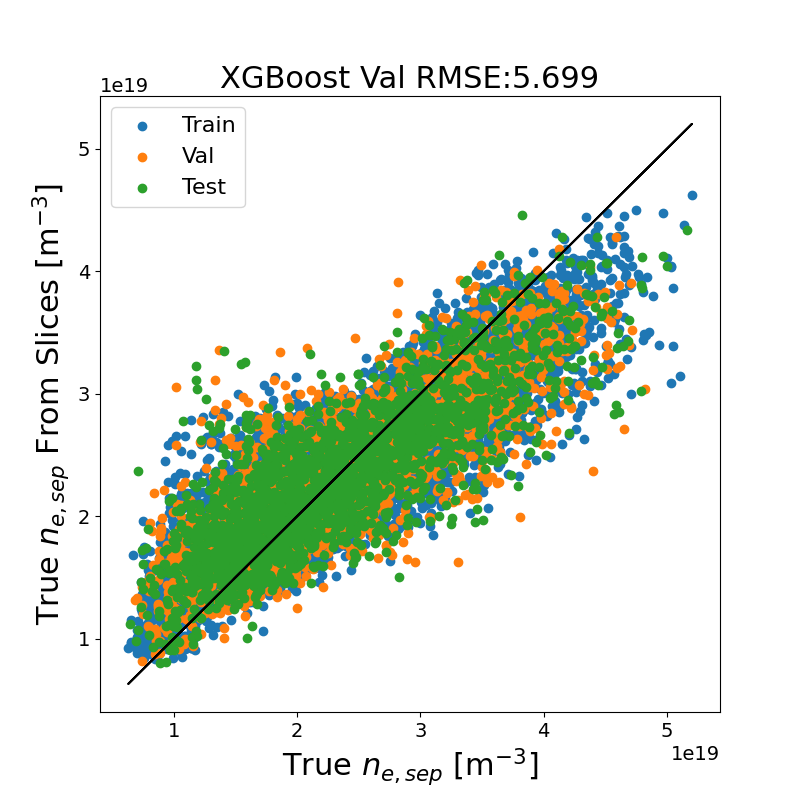

In [10]:
ypred_train = de_standardize(bst.predict(dtrain_all), N_mu, N_var)
ypred_val = de_standardize(bst.predict(dval_all), N_mu, N_var)
ypred_test = de_standardize(bst.predict(dtest_all), N_mu, N_var)

train_rmse = sklearn.metrics.mean_squared_error(ypred_train*1e-19, y_train*1e-19, squared=True)
val_rmse = sklearn.metrics.mean_squared_error(ypred_val*1e-19, y_val*1e-19, squared=True)
test_rmse = sklearn.metrics.mean_squared_error(ypred_test*1e-19, y_test*1e-19, squared=True)

plt.close('all')



fig = plt.figure(figsize=(8, 8))
plt.scatter(y_train_og, ypred_train, label='Train')
plt.plot(y_train_og, y_train_og, color='black')
plt.scatter(y_val_og, ypred_val, label='Val')
plt.scatter(y_test_og, ypred_test, label='Test')
plt.xlabel('True $n_{e,sep}$ [m$^{-3}$]')
plt.ylabel('True $n_{e,sep}$ From Slices [m$^{-3}$]')
plt.legend()
plt.title('XGBoost Val RMSE:{:.4}'.format(val_rmse))
plt.show()

In [29]:
from sklearn.model_selection import train_test_split

In [32]:
PULSE_DF_SANDBOX = JET_PDB[(JET_PDB['FLAG:HRTSdatavalidated'] > 0) & (JET_PDB['shot'] > 80000) & (JET_PDB['Atomicnumberofseededimpurity'].isin([0, 7])) & (JET_PDB['FLAG:DEUTERIUM'] == 1.0) & (JET_PDB['FLAG:Kicks'] == 0.0) & (JET_PDB['FLAG:RMP'] == 0.0) & (JET_PDB['FLAG:pellets'] == 0.0)]
relevant_columns = ['shot', 'nepedheight10^19(m^-3)','Tepedheight(keV)', 'B(T)','Ip(MA)', 'q95',  'R(m)', 'a(m)','gasflowrateofmainspecies10^22(e/s)',  'P_TOT=PNBI+Pohm+PICRH-Pshi(MW)', 'P_ICRH(MW)', 'P_NBI(MW)','plasmavolume(m^3)', 'averagetriangularity', 'divertorconfiguration', 'FLAG:Seeding', 'FLAG:Kicks',
 'FLAG:RMP',
 'FLAG:pellets',]

mp_cols = ['B(T)','Ip(MA)', 'q95',  'R(m)', 'a(m)','gasflowrateofmainspecies10^22(e/s)',  'P_TOT=PNBI+Pohm+PICRH-Pshi(MW)', 'P_ICRH(MW)', 'P_NBI(MW)','plasmavolume(m^3)', 'averagetriangularity']

In [41]:

X, y = PULSE_DF_SANDBOX[mp_cols], PULSE_DF_SANDBOX['neseparatrixfromfit10^19(m^-3)']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.3, random_state=42)


data_train_all_norm,  MP_mu, MP_var = standardize(X_train, None, None)
data_val_all_norm = standardize(X_val,  MP_mu, MP_var)
data_test_all_norm = standardize(X_test,  MP_mu, MP_var)


nesep_train_all_norm, NSEP_mu, NSEP_var = standardize(y_train, None, None)
nesep_val_all_norm = standardize(y_val, NSEP_mu, NSEP_var)
nesep_test_all_norm = standardize(y_test, NSEP_mu, NSEP_var)


In [51]:
dtrain_all = xgb.DMatrix(data_train_all_norm, nesep_train_all_norm)
dval_all = xgb.DMatrix(data_val_all_norm, nesep_val_all_norm)
dtest_all = xgb.DMatrix(data_test_all_norm, nesep_test_all_norm)

# evallist = [(dtest, 'eval'), (dtrain, 'train')]
evallist_all = [(dval_all, 'eval'), (dtrain_all, 'train')]

num_round = 100
param = {'max_depth': 3, 'eta': 0.1, 'gamma':0.00, 'objective': 'reg:squarederror'}
bst = xgb.train(param, dtrain_all, num_round, evallist_all)
# ypred_train = bst.predict(dtrain)

[0]	eval-rmse:0.98310	train-rmse:1.04297
[1]	eval-rmse:0.91925	train-rmse:0.97702
[2]	eval-rmse:0.86328	train-rmse:0.91959
[3]	eval-rmse:0.81332	train-rmse:0.86907
[4]	eval-rmse:0.77134	train-rmse:0.82552
[5]	eval-rmse:0.73631	train-rmse:0.78792
[6]	eval-rmse:0.70444	train-rmse:0.75343
[7]	eval-rmse:0.67488	train-rmse:0.71979
[8]	eval-rmse:0.64928	train-rmse:0.69297
[9]	eval-rmse:0.62648	train-rmse:0.66668
[10]	eval-rmse:0.60643	train-rmse:0.64587
[11]	eval-rmse:0.59310	train-rmse:0.62851
[12]	eval-rmse:0.57933	train-rmse:0.61031
[13]	eval-rmse:0.56594	train-rmse:0.59626
[14]	eval-rmse:0.55507	train-rmse:0.58138
[15]	eval-rmse:0.54733	train-rmse:0.57028
[16]	eval-rmse:0.53746	train-rmse:0.55984
[17]	eval-rmse:0.53071	train-rmse:0.54896
[18]	eval-rmse:0.52633	train-rmse:0.54091
[19]	eval-rmse:0.52007	train-rmse:0.53321
[20]	eval-rmse:0.51581	train-rmse:0.52467
[21]	eval-rmse:0.51248	train-rmse:0.51908
[22]	eval-rmse:0.50835	train-rmse:0.51335
[23]	eval-rmse:0.50613	train-rmse:0.50658
[2

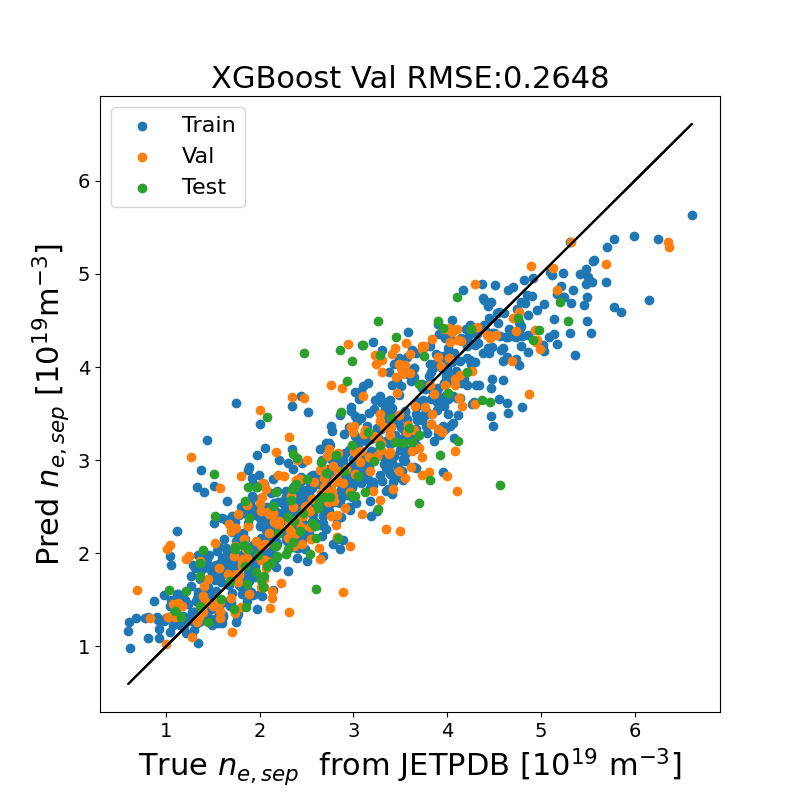

In [54]:

ypred_train = de_standardize(bst.predict(dtrain_all), NSEP_mu, NSEP_var)
ypred_val = de_standardize(bst.predict(dval_all), NSEP_mu, NSEP_var)
ypred_test = de_standardize(bst.predict(dtest_all), NSEP_mu, NSEP_var)

train_rmse = sklearn.metrics.mean_squared_error(ypred_train, y_train, squared=True)
val_rmse = sklearn.metrics.mean_squared_error(ypred_val, y_val, squared=True)
test_rmse = sklearn.metrics.mean_squared_error(ypred_test, y_test, squared=True)

plt.close('all')



fig = plt.figure(figsize=(8, 8))
plt.scatter(y_train, ypred_train, label='Train')
plt.plot(y_train, y_train, color='black')
plt.scatter(y_val, ypred_val, label='Val')
plt.scatter(y_test, ypred_test, label='Test')
plt.xlabel('True $n_{e,sep}$  from JETPDB [10$^{19}$ m$^{-3}$]')
plt.ylabel('Pred $n_{e,sep}$ [10$^{19}$m$^{-3}$]')
plt.legend()
plt.title('XGBoost Val RMSE:{:.4}'.format(val_rmse))
plt.show()